# Conformer model

This notebook runs through the designing and hyperparameter selection process for the Transformer model.

To do this we follow the steps:

+ Import the data
+ Design a preliminary model and test on the six different pre-processed data types
    + Proceed with the best one
+ Tune the hyperparameters
    + Test more transformer blocks.

In [1]:
#set up the workspace, environment and load libraries
#----------------------------------------------------
#Set sytem version
import sys
assert sys.version_info >= (3, 7)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#import sklearn
import sklearn
assert sklearn.__version__>="0.20"

#import tensorflow
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

#import libraries
import pandas as pd
import numpy as np
import pandas as pd
import G9_functions

#Figure setup
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Load the Datafiles

In [3]:
#load the three different frame types
padded_trunc_mfcc_50_path="Data/padded_truncated_mfcc_50ms.csv" #soundfiles split to 50ms
padded_trunc_mfcc_100_path="Data/padded_truncated_mfcc_100ms.csv" #soundfiles split to 100ms frames
padded_trunc_mfcc_500_path="Data/padded_truncated_mfcc_500ms.csv" #soundfiles split to 500ms frames

#Read into dataframes
padded_trunc_mfcc_50 = pd.read_csv(padded_trunc_mfcc_50_path)
padded_trunc_mfcc_100 =  pd.read_csv(padded_trunc_mfcc_100_path)
padded_trunc_mfcc_500 =  pd.read_csv(padded_trunc_mfcc_500_path)

#collect truncation lengths
truncation_length_dic={ "padded_trunc_mfcc_50":padded_trunc_mfcc_50.iloc[0, -1],
                       "padded_trunc_mfcc_100":padded_trunc_mfcc_100.iloc[0, -1],
                       "padded_trunc_mfcc_500":padded_trunc_mfcc_500.iloc[0, -1]
                      }

In [5]:
# Define the mapping dictionary
label_mapping = {'S1': 1,'S2': 1,'S3': 1, 'N': 0}

# Replace values in the 'label' column using the mapping dictionary
padded_trunc_mfcc_50['label'] = padded_trunc_mfcc_50['label'].replace(label_mapping)
padded_trunc_mfcc_100['label'] = padded_trunc_mfcc_100['label'].replace(label_mapping)
padded_trunc_mfcc_500['label'] = padded_trunc_mfcc_500['label'].replace(label_mapping)

### Prepare Data for transformer

In [6]:
def prepare_X_y_sequences_mfcc_data(df,num_mfccs,truncated_length):
    mfcc_columns = [f'mfcc_{i}' for i in range(1, num_mfccs+1)] #list of the MFCC values
    X = np.array([df[mfcc_column].apply(eval).tolist() for mfcc_column in mfcc_columns]) #merge the MFCC for each instance to a single list e.g. [mfcc1,mfcc2,...,mfcc13]time,
    X = X.transpose(1, 0, 2)  # Transpose to (13, number_of_samples, reference_length)
    X = X.reshape(-1, truncated_length, 13)
    y = df['label']
    return X, y

In [7]:
X_50,y_50 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_50,13,truncation_length_dic.get("padded_trunc_mfcc_50"))

X_100,y_100 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_100,13,truncation_length_dic.get("padded_trunc_mfcc_100"))

X_500,y_500 = prepare_X_y_sequences_mfcc_data(padded_trunc_mfcc_500,13,truncation_length_dic.get("padded_trunc_mfcc_500"))

### Test Train Split

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Function to create test, train, val datasets
def train_test_val_datasets_mfcc_sequences(X, y, test_size=0.2, val_size=0.15, stratify=True, random_state=False, scale=False, num_mfccs=False):
    
    val_size = 0.15/ (1-test_size) #
    
    if stratify is True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y,shuffle=True,random_state=random_state)
        if scale is True:
            
            #Obtain shapes
            X_train_shape=X_train.shape
            X_test_shape=X_test.shape
            
            #scale the MFCCs on the training set
            scaler = StandardScaler()
            scaler.fit(X_train.reshape(-1,num_mfccs))
            X_train = scaler.transform(X_train.reshape(-1,num_mfccs))
            X_test=scaler.transform(X_test.reshape(-1,num_mfccs))
            
            #reshape back into sequences of MFCCS
            X_train = X_train.reshape(X_train_shape)
            X_test = X_test.reshape(X_test_shape)
            
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train,shuffle=True, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,shuffle=True,random_state=random_state)
        if scale is True:
            
            #Obtain shapes
            X_train_shape=X_train.shape
            X_test_shape=X_train.shape
            
            #scale the MFCCs on the training set
            scaler = StandardScaler()
            scaler.fit(X_train.reshape(-1,num_mfccs))
            X_train = scaler.transform(X_train.reshape(-1,num_mfccs))
            X_test=scaler.transform(X_test.reshape(-1,num_mfccs))
            
            #reshape back into sequences of MFCCS
            X_train = X_train.reshape(X_train_shape)
            X_test = X_test.reshape(X_test_shape)
            
        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size,shuffle=True, random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test
    

In [58]:
X_train_50, y_train_50, X_val_50, y_val_50, X_test_50, y_test_50 = train_test_val_datasets_mfcc_sequences(X=X_50, y=y_50, test_size=0.2, val_size=0.15,stratify=True,random_state=False,scale=True, num_mfccs=13)

X_train_100, y_train_100, X_val_100, y_val_100, X_test_100, y_test_100 =train_test_val_datasets_mfcc_sequences(X=X_100,y=y_100,test_size=0.2,val_size=0.15,stratify=True,random_state=False, scale=True,num_mfccs=13)

X_train_500, y_train_500, X_val_500, y_val_500, X_test_500, y_test_500 = train_test_val_datasets_mfcc_sequences(X=X_500,y=y_500,test_size=0.2,val_size=0.15,stratify=True,random_state=False, scale=True,num_mfccs=13)

In [60]:
print("X shape:", X_500.shape)
print("y:", y_500.shape)
print("X_train shape:", X_train_500.shape)
print("X_val shape:", X_val_500.shape)
print("X_test shape:", X_test_500.shape)
print("y_train shape:", y_train_500.shape)
print("y_val shape:", y_val_500.shape)
print("y_test shape:", y_test_500.shape)

X shape: (38392, 12, 13)
y: (38392,)
X_train shape: (24954, 12, 13)
X_val shape: (5759, 12, 13)
X_test shape: (7679, 12, 13)
y_train shape: (24954,)
y_val shape: (5759,)
y_test shape: (7679,)


# Conformer model

#### Part 1: Define a simple Conformer architecture

In [280]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention as ConformerMultiHeadAttention

# Custom GLU activation function
def glu(x):
    # Split the input tensor into two parts along the last axis
    x1, x2 = tf.split(x, 2, axis=-1)
    
    # Apply the sigmoid activation function to the second half
    x2 = tf.sigmoid(x2)
    
    # Element-wise multiplication of x1 and x2
    return x1 * x2

#create a custome conformer block

class Conformer(layers.Layer):
    def __init__(self, num_heads=4,key_dim=13,value_dim=13,dropout=0.1,filters=64,**kwargs):
        
        super(Conformer, self).__init__(**kwargs)
        
        
        #Convolutional module as shown in l Gulati et al. (2020)
        self.convolution_module = keras.Sequential([
            
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv1D(filters, kernel_size=1), #pointwise convolutional layer
            layers.Activation(glu),
            
            layers.DepthwiseConv1D(kernel_size=3, padding="same",use_bias=False),
            layers.BatchNormalization(),
            layers.Activation("swish"),
            
            layers.Conv1D(13 , kernel_size=1),  #pointwise convolutional layer
            layers.Activation('relu'),
            layers.Dropout(dropout)
            
            ])
        
        #Multi-Head attention component
        self.multi_head_attention_module = ConformerMultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, value_dim=value_dim, dropout=dropout)
    
    
        
        # Feedforward block at the end
        self.ff_module_end = keras.Sequential([
            layers.Conv1D(filters , kernel_size=1),  #pointwise convolutional layer
            layers.Activation('relu'),
            layers.Dense(13,kernel_initializer='he_normal',use_bias=False),
            layers.Activation('relu'),
            layers.BatchNormalization()
        ])
            
        
        # Addition layer for residual connection
        self.addition = layers.Add()
        
        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)

        
    
    def call(self, inputs, training=False):
        
        #feedforward block START
        #ffn_start_output = self.ff_module_start(inputs)
            
        #Convolutional block
        ffn_conv_output = self.convolution_module(inputs)
        
        #Addition  
        ffn_conv_output  = self.addition([inputs, ffn_conv_output])
        
        
        #Multi-HEad attension block
        attention_output = self.multi_head_attention_module(ffn_conv_output , ffn_conv_output , ffn_conv_output , training=training)
        
        #Addition  
        attention_output = self.addition([ffn_conv_output, attention_output])
        
        
        
        
        
        #feedforwardblock END
        ffn_end_output = self.ff_module_end(attention_output)
        
        #Addition  
        ffn_end_output = self.addition([attention_output, ffn_end_output])
            
        #layer normalisation layer
        ffn_end_output = self.layernorm1( ffn_end_output, training=training)
        
        return ffn_end_output
    

# Define the Transformer model for the mfcc_sequences
def create_conformer_model_mfcc_sequences(max_seq_length, num_classes, num_mfcc_features):
    
    inputs = keras.Input(shape=(max_seq_length, num_mfcc_features))  # Input shape for MFCCs
    
    # Add a masking layer to ignore sequences containing padding tokens 
    mask = layers.Masking(mask_value=[0.0] * num_mfcc_features)(inputs) 
    
    
    # Multi-Head Self-Attention layer
    conformer_output = Conformer()(mask)
    conformer_output1= Conformer()(conformer_output)

 
    
    # Global Average Pooling to reduce sequence length
    avg_pooling = layers.GlobalAveragePooling1D()(conformer_output1)
    
    # Output layer for classification
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(avg_pooling)
    
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(avg_pooling)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

#### Part 2: Compare the time splits

In [188]:
conformer_model_50 = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_50"), 2,13)

conformer_model_100 = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_100"), 2,13)

conformer_model_500 = create_conformer_model_mfcc_sequences(truncation_length_dic.get("padded_trunc_mfcc_500"), 2,13)

In [189]:
# Compile the models
conformer_model_50.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
conformer_model_100.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
conformer_model_500.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [153]:
# Define the number of epochs and batch size
epochs = 20
batch_size = 32

# Fit the models
history_50 = conformer_model_50.fit(X_train_50, y_train_50,epochs=epochs,batch_size=batch_size,validation_data=(X_val_50, y_val_50))
history_100 = conformer_model_100.fit(X_train_100, y_train_100,epochs=epochs,batch_size=batch_size,validation_data=(X_val_100, y_val_100))
history_500 = conformer_model_500.fit(X_train_500, y_train_500,epochs=epochs,batch_size=batch_size,validation_data=(X_val_500, y_val_500))


Epoch 1/20
780/780 [==============================] - 95s 118ms/step - loss: 0.2860 - accuracy: 0.8793 - val_loss: 0.2353 - val_accuracy: 0.8984
Epoch 2/20
780/780 [==============================] - 89s 115ms/step - loss: 0.2179 - accuracy: 0.9029 - val_loss: 0.1966 - val_accuracy: 0.9102
Epoch 3/20
780/780 [==============================] - 88s 113ms/step - loss: 0.1970 - accuracy: 0.9127 - val_loss: 0.2474 - val_accuracy: 0.9031
Epoch 4/20
780/780 [==============================] - 87s 112ms/step - loss: 0.1909 - accuracy: 0.9144 - val_loss: 0.3518 - val_accuracy: 0.8727
Epoch 5/20
780/780 [==============================] - 87s 111ms/step - loss: 0.1837 - accuracy: 0.9166 - val_loss: 0.2180 - val_accuracy: 0.8908
Epoch 6/20
780/780 [==============================] - 88s 113ms/step - loss: 0.1778 - accuracy: 0.9198 - val_loss: 0.1862 - val_accuracy: 0.9201
Epoch 7/20
780/780 [==============================] - 87s 112ms/step - loss: 0.1733 - accuracy: 0.9220 - val_loss: 0.1797 - val_ac

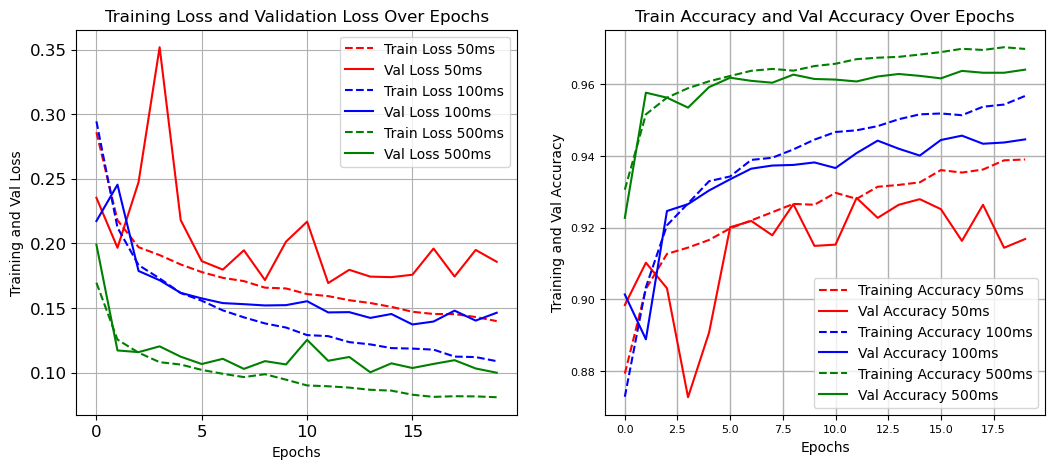

In [154]:
history_dic={'50ms':history_50,
             '100ms':history_100,
             '500ms':history_500,
}
G9_functions.plot_learning_curves(history_dic)

The learning curves show that the models using the 500ms are the best with the lowest and most stable validation and training loss.

We will continue with the 500ms dataset for training the hyperparameters of the transformer model.

## Hyperparameter Tuning

This section will attempt to tune the hyperparameters for the simple transformer model architecture. This will be acheived using `keras_tuner`.

This will be done in two phases. Phase 1 will test the 



In [252]:
from keras_tuner.tuners import Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    max_seq_length =12
    num_classes=2
    num_mfcc_features=13
 
    inputs = keras.Input(shape=(max_seq_length, num_mfcc_features))  # Input shape for MFCCs
    
    # Add a masking layer to ignore sequences containing padding tokens 
    mask = layers.Masking(mask_value=[0.0] * num_mfcc_features)(inputs) 
    
    
    # Hyperparameters to tune
    num_conformer_blocks = hp.Int('num_conformer_blocks', min_value=1, max_value=6, step=1)
    num_heads = hp.Int('num_heads', min_value=2, max_value=10, step=2)
    num_filters = hp.Int('num_filters', min_value=16, max_value=64, step=16)
    learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='LOG', default=1e-3)
    dropout_rate_tf = hp.Float('dropout_rate_tf',min_value=0.1, max_value=0.3, step=0.1)

    
    # Conformer Block
    for _ in range(num_conformer_blocks):
        conformer_output = Conformer(num_heads=num_heads,
                                              key_dim=num_mfcc_features,
                                              value_dim=num_mfcc_features,
                                              dropout=dropout_rate_tf,filters=num_filters)(mask)
        
    
        
    # Global Average Pooling to reduce sequence length
    avg_pooling = layers.GlobalAveragePooling1D()(conformer_output)
    
    # Output layer for classification
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(avg_pooling)
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(avg_pooling)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def tune_hyperparameters(X_train,y_train,X_val,y_val,num_classes):
    tuner = Hyperband(build_model,
                      objective='val_loss',
                      max_epochs=30,
                      factor=3,
                      directory='hyperband',
                      project_name='conformer_hyperparameters')
    
    tuner.search_space_summary()
    
    # Perform the hyperparameter search
    tuner.search(x=X_train, y=y_train, validation_data=(X_val, y_val))
    
    # Get the top 3 best performing hyperparameter configurations
    top_3_trials = tuner.oracle.get_best_trials(num_trials=3)
    
    best_models = []
    for trial in top_3_trials:
        best_hps = trial.hyperparameters
        model = tuner.hypermodel.build(best_hps)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
                      loss='binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        best_models.append(model)
        
        print(f"Trial ID: {trial.trial_id}, Validation Accuracy: {trial.score}")
    
    return best_models,top_3_trials


In [250]:
# Clean up backend resources
tf.keras.backend.clear_session()

import shutil

# Replace 'hyperband/transformer_hyperparameters' with your tuner's directory
#shutil.rmtree('hyperband/conformer_hyperparameters')


In [251]:
best_models,top_3_trials=tune_hyperparameters(X_train_500,y_train_500,X_val_500,y_val_500,num_classes=2)

Trial 90 Complete [00h 03m 08s]
val_loss: 0.31116271018981934

Best val_loss So Far: 0.09093806892633438
Total elapsed time: 01h 13m 41s
INFO:tensorflow:Oracle triggered exit
Trial ID: 0050, Validation Accuracy: 0.09093806892633438
Trial ID: 0051, Validation Accuracy: 0.09286625683307648
Trial ID: 0046, Validation Accuracy: 0.0932803750038147


In [253]:
top_3_trials[0].hyperparameters.values

{'num_conformer_blocks': 4,
 'num_heads': 8,
 'num_filters': 64,
 'learning_rate': 0.002107555378440873,
 'dropout_rate_tf': 0.1,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046'}

In [254]:
top_3_trials[1].hyperparameters.values

{'num_conformer_blocks': 5,
 'num_heads': 6,
 'num_filters': 32,
 'learning_rate': 0.0008481783832734692,
 'dropout_rate_tf': 0.1,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0047'}

In [255]:
top_3_trials[2].hyperparameters.values

{'num_conformer_blocks': 4,
 'num_heads': 8,
 'num_filters': 64,
 'learning_rate': 0.002107555378440873,
 'dropout_rate_tf': 0.1,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '0035'}

The hyperparameter tuning process using keras hyperband has shown that a depper model with 6 tranformer layers and 4 feed forward hidden layers provided the best results. For the feedforward layer usingt he swish activation 

## Train- best model

In [288]:
# Define the Transformer model for the mfcc_sequences
def create_conformer_model_mfcc_sequences_optimal(max_seq_length, num_classes, num_mfcc_features):
    
    inputs = keras.Input(shape=(max_seq_length, num_mfcc_features))  # Input shape for MFCCs
    
    # Add a masking layer to ignore sequences containing padding tokens 
    mask = layers.Masking(mask_value=[0.0] * num_mfcc_features)(inputs) 
    
    
    # Multi-Head Self-Attention layer
    conformer_output = Conformer(num_heads=8, key_dim=num_mfcc_features, value_dim=num_mfcc_features, dropout=0.2,filters=40)(mask)

 
    
    # Global Average Pooling to reduce sequence length
    avg_pooling = layers.GlobalAveragePooling1D()(conformer_output)
    
    # Output layer for classification
    if num_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(avg_pooling)
    
    else:
        outputs = layers.Dense(num_classes, activation="softmax")(avg_pooling)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [289]:
#best_conformer_model = best_models[0]

best_conformer_model = create_conformer_model_mfcc_sequences_optimal(truncation_length_dic.get("padded_trunc_mfcc_500"), 2,13)

best_conformer_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 12, 13)]          0         
                                                                 
 masking_11 (Masking)        (None, 12, 13)            0         
                                                                 
 conformer_31 (Conformer)    (None, 12, 13)            7890      
                                                                 
 global_average_pooling1d_1  (None, 13)                0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dense_91 (Dense)            (None, 1)                 14        
                                                                 
Total params: 7904 (30.88 KB)
Trainable params: 7838 (30.62 KB)
Non-trainable params: 66 (264.00 Byte)
_____________________

In [290]:
best_conformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=top_3_trials[0].hyperparameters.values.get('learning_rate')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

#Early Stopping
early_stopping=tf.keras.callbacks.EarlyStopping(start_from_epoch=10,patience=20,monitor='val_loss',restore_best_weights=True)

#Learning rate scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5)

history_best_model = best_conformer_model.fit(X_train_500, y_train_500,
                                                epochs=500,batch_size=32,
                                                validation_data=(X_val_500, y_val_500),
                                                callbacks=[lr_scheduler,early_stopping])




Epoch 1/500
780/780 [==============================] - 8s 7ms/step - loss: 0.1780 - accuracy: 0.9268 - val_loss: 0.1578 - val_accuracy: 0.9314 - lr: 0.0021
Epoch 2/500
780/780 [==============================] - 5s 6ms/step - loss: 0.1289 - accuracy: 0.9517 - val_loss: 0.1190 - val_accuracy: 0.9531 - lr: 0.0021
Epoch 3/500
780/780 [==============================] - 5s 6ms/step - loss: 0.1195 - accuracy: 0.9534 - val_loss: 0.1623 - val_accuracy: 0.9292 - lr: 0.0021
Epoch 4/500
780/780 [==============================] - 5s 6ms/step - loss: 0.1152 - accuracy: 0.9562 - val_loss: 0.1175 - val_accuracy: 0.9561 - lr: 0.0021
Epoch 5/500
780/780 [==============================] - 5s 6ms/step - loss: 0.1112 - accuracy: 0.9578 - val_loss: 0.1076 - val_accuracy: 0.9599 - lr: 0.0021
Epoch 6/500
780/780 [==============================] - 5s 6ms/step - loss: 0.1072 - accuracy: 0.9604 - val_loss: 0.1046 - val_accuracy: 0.9604 - lr: 0.0021
Epoch 7/500
780/780 [==============================] - 5s 6ms/st

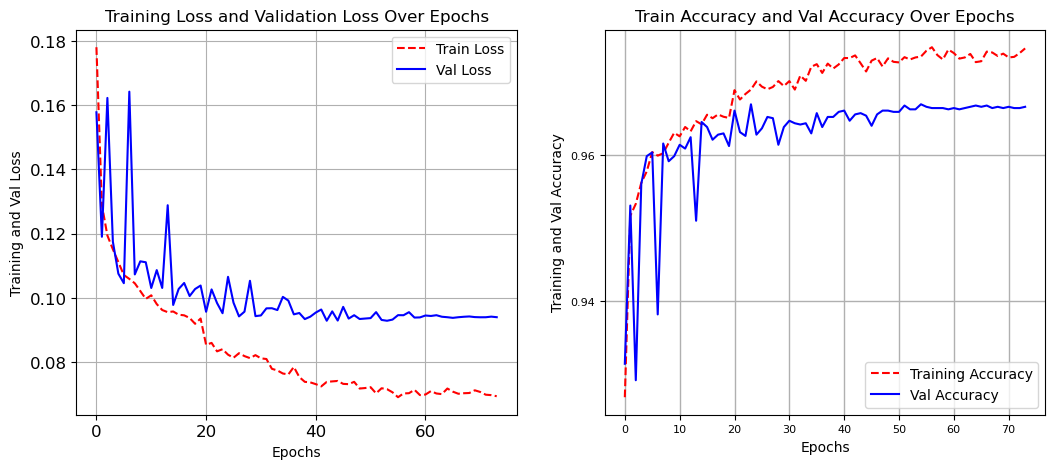

In [291]:
G9_functions.plot_learning_curves({'best_model':history_best_model})

The conformer model shows a slight improvement over the transformer model. The model does appear to be overfitting with the addition of the convolutional blocks. This is only small though.

In [292]:
model_file_path = "Snoring_Binary_Conformer_Model" #model file path
best_conformer_model.save(model_file_path,save_format="tf")

INFO:tensorflow:Assets written to: Snoring_Binary_Conformer_Model\assets


INFO:tensorflow:Assets written to: Snoring_Binary_Conformer_Model\assets


### Choosing a threshold

In this section we want to determine if a threshold of 0.5 is adequate. To do this the precision and recall curves will be examined for the validation dataset.

In [293]:
y_proba_val = best_conformer_model.predict(X_val_500)

180/180 [==============================] - 1s 3ms/step


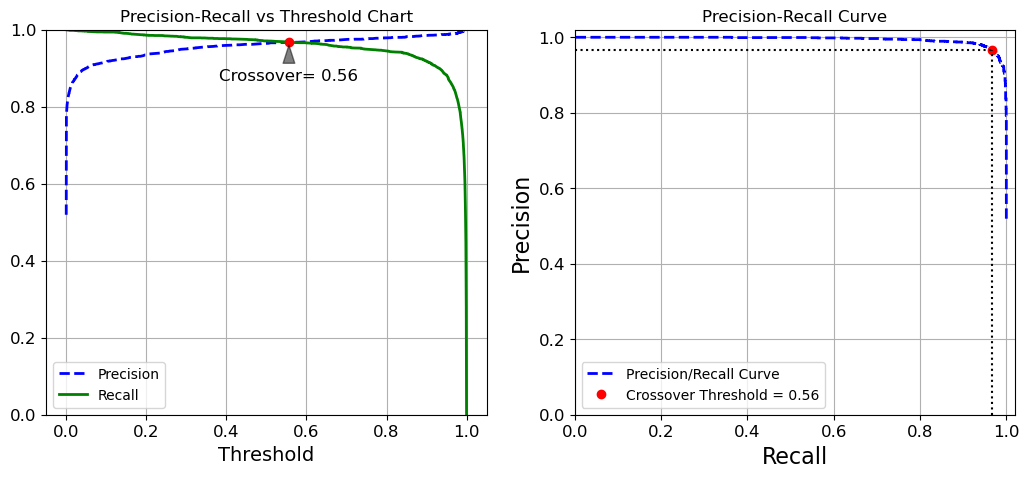

In [294]:
G9_functions.precision_recall_threshold_charts(y_val_500,y_proba_val,crossover=True)

The precision-recall curves for the validation dataset crossover when the threshold is equal to 0.61. The aim is to limit false positives or increase precision so having a slightly higher threshold may prove more valuable. Using a threshold of 0.6 might be better suited.

# Performance Metrics

In [296]:
y_proba_test = best_conformer_model.predict(X_test_500)
threshold=0.56
y_pred_test =(y_proba_test >= threshold).astype(int)

240/240 [==============================] - 1s 3ms/step


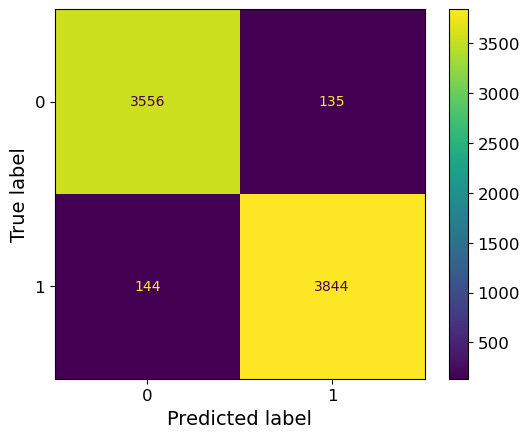

In [298]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report, precision_recall_curve, confusion_matrix,precision_score, recall_score
cm_fig=ConfusionMatrixDisplay(confusion_matrix(y_test_500,y_pred_test))
cm_fig.plot()

In [299]:
from sklearn.metrics import classification_report
print(classification_report(y_test_500,y_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3691
           1       0.97      0.96      0.96      3988

    accuracy                           0.96      7679
   macro avg       0.96      0.96      0.96      7679
weighted avg       0.96      0.96      0.96      7679



The CM and classification report show that the model has an accuracy of **96%** on the test dataset and a precsion of **97%**. These results are highly promising.

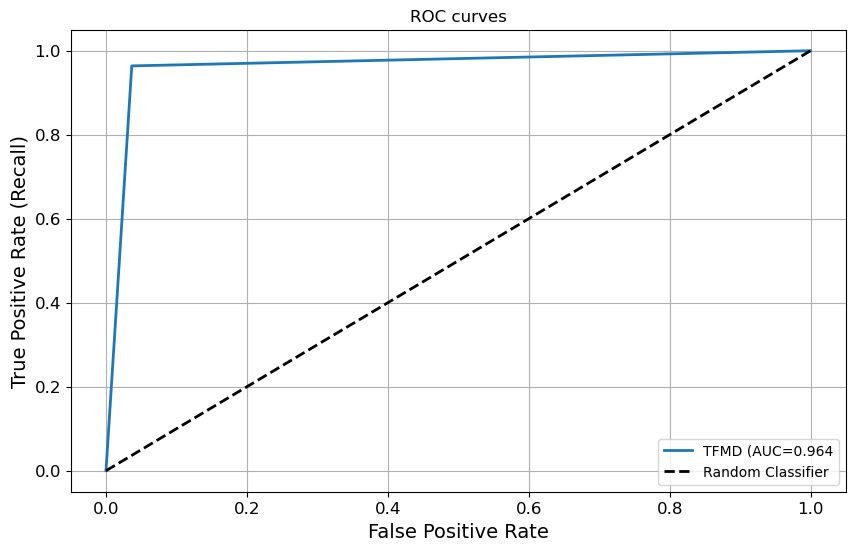

In [302]:
G9_functions.plot_roc_curves(y_test_500, {'TFMD':y_pred_test})